This code is to fit a spectrum as the sum of two models, and really it's a sum of four models. 

The goal is to map out the space of possible delta-Teff and spot coverage fractions allowed.
I suspect I will have to run this with a prior on either delta-Teff or fS to get something meaningful because of degeneracies

To do:
<br /> -Test with models against models
<br /> -Read in observed spectra of K2-33
<br /> -Test LkCa 4 (if we have a spectrum)?
<br /> -Down-sample and smooth models to match data
<br /> -Test with fS = 0

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
import healpy as hp
from lightkurve import search_lightcurvefile
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from multiprocessing import Pool
from scipy import stats
import numpy.random as random
from scipy import optimize
import emcee
import corner
import random

import multiprocessing as mp
Pool = mp.get_context('fork').Pool

In [2]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

In [3]:
#modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

print(np.min(data['teff']),np.max(data['teff']))
print(data['header'])

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   
500.0 3900.0
[['SIMPLE  =                    T / Written by IDL:  Sun Apr 17 10:22:04 2016'
  'BITPIX  =                  -32 / Number of bits per data pixel'
  'NAXIS   =                    2 / Number of data axes'
  'NAXIS1  =                  296 /' 'NAXIS2  =               149501 /'
  "DATE    = '2016-04-17'         / Creation UTC (CCCC-MM-DD) date of FITS header"
  'NMODEL  =                  296 /number of models'
  'NLAMBDA =               149501 /number of wavelengths'
  'LAMBDA_0=              1000.00 /starting wavelength in Angstroms'
  'D_LAMBDA=              2.00000 /increment in Angstroms'
  "COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy"
  "COMMENT and Astrophy

In [74]:
## trim the models to just solar metallicity 

teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])

#for i,j,k,l in zip(teff,logg,afe,mh):
#    print(i,j,k,l)

loc = np.where((logg == 4.5) & (mh == 0) & (teff > 1000) & (afe == 0))
modelteff = teff[loc]
modelspectra = np.squeeze(spectra[:,loc])
lambda0 = 1000
nlambda = 149501
dlambda = 2
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)

ll = np.where((modelwave > 3400) & (modelwave < 53000))
print(np.shape(ll))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]
print(np.shape(modelteff),np.shape(modelspectra),np.shape(modelwave))
print(np.max(modelteff),np.min(modelteff))

(1, 24800)
(29,) (24800, 29) (24800,)
3900.0 1100.0


In [75]:
from gaussfold import gaussfold as gf
## resample model spectra
newlambda = np.linspace(4000,23000,num=10000)

newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = modelspectra[:,i]
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, 3)
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

In [76]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

In [77]:
## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

In [78]:
## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, loff, f = theta
    if (loff < -2) or (loff > 2) or (Tspot < 1500) or (Tspot > 3900) or (Tsurf < 1500) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 5:
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    Tsurf, Tspot, fS, a, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)

    modelspec_smooth = modelspec_shift/(a)  
    
    s_squared = np.square(obserr*(1.+f))
    p = (1. / np.sqrt(2 * np.pi * s_squared)) * np.exp(-np.square(modelspec_smooth - obsspec) / (2 * s_squared)) 
    output = np.sum(np.log(p))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

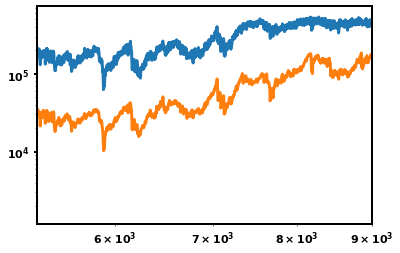

if this is inf, we have a problem:
-472911.0480664984


In [79]:
nwalkers, ndim = 30, 6
nthreads = 12
initial_guesses = [3800, 3000, 0.6, 1, 0.1, 0.1]
testspec = doublespec(modelteff,modelspectra,3500,2500,0.9)
obsspec = doublespec(modelteff,modelspectra,3470,1900,0.3)
obserr = obsspec*0.05
for i in range(0,np.size(obsspec)) :
    obsspec[i] += np.random.normal(0,obsspec[i]*0.05,1)

plt.plot(modelwave,obsspec,label='obsspec')
plt.plot(modelwave,testspec,label='testspec')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5300,9000)
plt.show()

print('if this is inf, we have a problem:')
print(ln_posterior(initial_guesses,modelteff,modelspectra,modelwave,obsspec,obserr))
pos0 = [initial_guesses*(1+0.01*np.random.randn(ndim)) for i in range(nwalkers)]

In [80]:
nsteps = 10000
burn = 2000
thin = 1

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(modelteff,modelspectra,modelwave,obsspec,obserr), threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

100%|██████████| 5000/5000 [01:46<00:00, 46.98it/s]

done


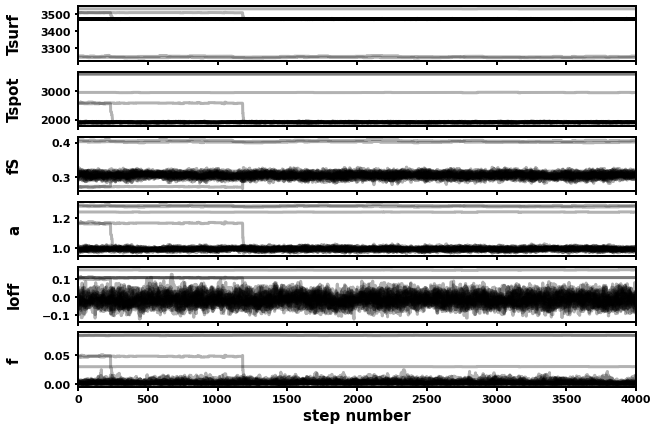

In [82]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Walkers_specfit.pdf')

(90000, 6)


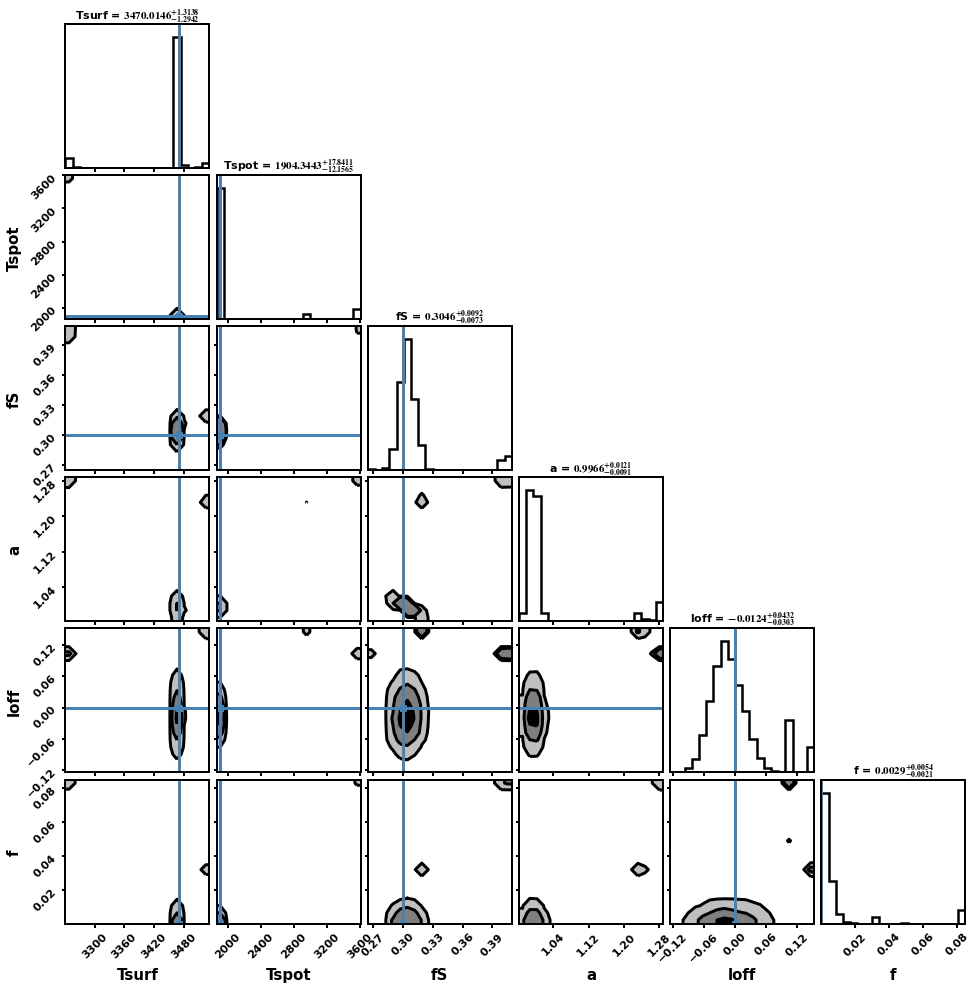

In [81]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
labels = ['Tsurf','Tspot','fS','a','loff','f']
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=True,truths=[3470,1900,0.3,0.0,0.0,0.0],
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec.pdf')